# Gluon and FARS Demo

*This notebook explores Gluon's api with transportation data*

In [23]:
# Code illustrating import of gluon library
!sudo pip install mxnet

import mxnet as mx
from mxnet import gluon, autograd, ndarray
import numpy as np

In [26]:
# Quick start example from: https://github.com/gluon-api/gluon-api/
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=lambda data, label: (data.astype(np.float32)/255, label)),
                                      batch_size=32, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=lambda data, label: (data.astype(np.float32)/255, label)),
                                     batch_size=32, shuffle=False)        

*What follows below is a demo developed by https://github.com/cheevahagadog/FARS-demos to provide code snippets and reference* 

*Pull any/all bits from below to load data and create a new demo with gluon*

# Jupyter Notebook FARS Demo

**Link to challenge details: https://www.bigdatahubs.io/ **  
**Link to data documentation: http://bit.ly/2vL2TfF  **  
**Link to data set: ftp://ftp.nhtsa.dot.gov/fars/2015/National/  ** 

Let's load some libraries that we'll be using:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from collections import Counter

let's decide on some graphic options. Since these data sets have so many columns, it might be nice to see more of them than the default. 

In [2]:
pd.set_option('max_columns', 110)
plt.style.use('ggplot')

Here we're reading in our data files and saving them as variables.

In [3]:
persons = pd.read_csv('data/person.csv')
accidents = pd.read_csv('data/accident.csv')
vehicles = pd.read_csv('data/vehicle.csv', encoding ='latin1')  # In case you get encoding errors

As per the documentation, certain fields can be used to match/join to other data sets.
- ST_CASE should be used to merge the Person data file with the Accident data file for a set of all motorists and non-motorists.
- ST_CASE and VEH_NO should be used to merge the Person data file with the Vehicle data files for a set of all motor vehicle occupants

### Let's start by looking at the `persons` data set. 
Information on variable meanings can be found on pg. 241 of the data documentation link at top.
Let's take a peek at what our data looks like

In [4]:
persons.head()

,STATE,ST_CASE,VE_FORMS,VEH_NO,PER_NO,STR_VEH,COUNTY,DAY,MONTH,HOUR,MINUTE,RUR_URB,FUNC_SYS,HARM_EV,MAN_COLL,SCH_BUS,MAKE,MAK_MOD,BODY_TYP,MOD_YEAR,TOW_VEH,SPEC_USE,EMER_USE,ROLLOVER,IMPACT1,FIRE_EXP,AGE,SEX,PER_TYP,INJ_SEV,SEAT_POS,REST_USE,REST_MIS,AIR_BAG,EJECTION,EJ_PATH,EXTRICAT,DRINKING,ALC_DET,ALC_STATUS,ATST_TYP,ALC_RES,DRUGS,DRUG_DET,DSTATUS,DRUGTST1,DRUGTST2,DRUGTST3,DRUGRES1,DRUGRES2,DRUGRES3,HOSPITAL,DOA,DEATH_DA,DEATH_MO,DEATH_YR,DEATH_HR,DEATH_MN,DEATH_TM,LAG_HRS,LAG_MINS,P_SF1,P_SF2,P_SF3,WORK_INJ,HISPANIC,RACE,LOCATION
0,1,10001,1,1,1,0,127,1,1,2,40,1,3,35,0,0,12.0,12481.0,31.0,2003.0,0.0,0.0,0.0,0.0,12.0,0.0,68,1,1,4,11,7,0,1,0,0,0,9,9,2,1,189,9,8,2,1,0,0,1,0,0,0,7,1,1,2015,2,40,240,0,0,0,0,0,0,7,1,0
1,1,10002,1,1,1,0,83,1,1,22,13,1,1,34,0,0,49.0,49040.0,4.0,2006.0,0.0,0.0,0.0,1.0,6.0,0.0,49,1,1,4,11,7,0,20,1,9,0,0,9,2,1,0,0,8,2,1,1,1,358,996,996,0,7,1,1,2015,22,13,2213,0,0,0,0,0,0,7,1,0
2,1,10003,1,1,1,0,11,1,1,1,25,1,3,42,0,0,20.0,20037.0,4.0,2008.0,0.0,0.0,0.0,1.0,12.0,1.0,31,1,1,4,11,7,0,1,0,0,0,1,9,2,1,188,9,8,2,1,0,0,1,0,0,0,7,1,1,2015,1,25,125,0,0,0,0,0,0,7,2,0
3,1,10003,1,1,2,0,11,1,1,1,25,1,3,42,0,0,20.0,20037.0,4.0,2008.0,0.0,0.0,0.0,1.0,12.0,1.0,20,2,2,2,13,7,0,1,0,0,0,8,9,0,0,996,8,8,0,0,0,0,0,0,0,5,0,88,88,8888,88,88,8888,999,99,0,0,0,8,0,0,0
4,1,10004,1,1,1,0,45,4,1,0,57,1,4,53,0,0,12.0,12481.0,31.0,2005.0,0.0,0.0,0.0,0.0,12.0,0.0,40,1,1,4,11,7,0,20,0,0,0,1,9,2,1,260,9,8,2,1,0,0,1,0,0,0,7,4,1,2015,0,57,57,0,0,0,0,0,0,7,1,0


Let's examine the distribution of `INJ_SEV` or injury severity particular:

In [5]:
persons['INJ_SEV'].describe()

count    80587.000000
mean         2.469654
std          1.786318
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          9.000000
Name: INJ_SEV, dtype: float64

I'm curious what the frequency of each kind of injury severity is. After refering to the data dictionary for this variable on pg. 245 I made a lookup dictionary.

In [6]:
inj_types = {
    '0': "No Apparent Injury",
    '1': "Possible Injury",
    '2': "Suspected Minor Injury",
    '3': "Suspected Serious Injury",
    '4': "Fatal Injury",
    '5': "Injured, Severity Unknown",
    '6': "Died Prior to Crash",
    '8': "Not Reported",
    '9': "Unknown"
}

Now we can count up the frequencies for each type of injury using a `Counter` dictionary

In [7]:
d = Counter(inj_types.get(str(row)) for row in persons['INJ_SEV'])

Here's what frequency looks like:

In [8]:
d

Counter({'Died Prior to Crash': 2,
         'Fatal Injury': 35092,
         'Injured, Severity Unknown': 250,
         'No Apparent Injury': 19704,
         'Possible Injury': 7400,
         'Suspected Minor Injury': 9045,
         'Suspected Serious Injury': 8324,
         'Unknown': 770})

To help with plotting, let's sort it into a list

In [9]:
s_list = sorted(d.items(), key=lambda x: x[1])
s_list

[('Died Prior to Crash', 2),
 ('Injured, Severity Unknown', 250),
 ('Unknown', 770),
 ('Possible Injury', 7400),
 ('Suspected Serious Injury', 8324),
 ('Suspected Minor Injury', 9045),
 ('No Apparent Injury', 19704),
 ('Fatal Injury', 35092)]

Plotting with the labeled categories helps visualize the frequency of different types of injury severities. 

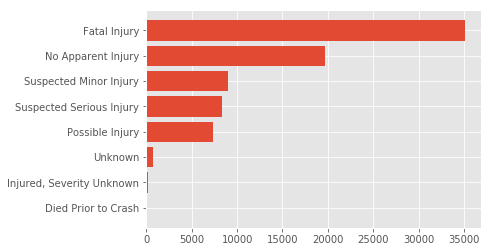

In [10]:
plt.barh(bottom=range(len(s_list)), width=list(zip(*s_list))[1], tick_label=list(zip(*s_list))[0]);

This graph is sobering showing that fatal injuries are the most common type of injury. Interestingly the second-most common injury type is `No Apparent Injury`. It's definitely worth looking into what other variables separate out those top two injury types.

We can get a high-level glance at a couple variables' distributions

In [11]:
persons[['AGE', 'HOUR']].describe()

,AGE,HOUR
count,80587.000000,80587.000000
mean,58.975281,13.517999
std,138.082198,8.828619
min,0.000000,0.000000
25%,23.000000,8.000000
50%,37.000000,14.000000
75%,55.000000,19.000000
max,999.000000,99.000000


FARS sometimes uses `999` to stand in for an unknown value. Since those max values don't make sense, we can filter them out temporarily to explore `AGE` and `HOUR` distributions

In [12]:
df = persons[(persons['AGE'] < 121) & (persons['HOUR'] <25)]

Now we see distributions that make more sense:

In [13]:
df[['AGE', 'HOUR']].describe()

,AGE,HOUR
count,78588.000000,78588.000000
mean,39.119115,13.126890
std,20.330203,6.638303
min,0.000000,0.000000
25%,23.000000,8.000000
50%,36.000000,14.000000
75%,54.000000,19.000000
max,114.000000,23.000000


### Age distribution
Here we plot a histogram of age frequencies:

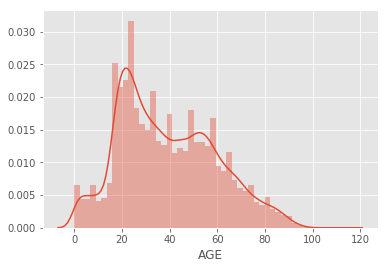

In [14]:
sns.distplot(df['AGE']);

We see a high peak in the early twenties followed by general decline as age increases with a slight rise around the fifties.

### What if I want to see if there's a correlation between `AGE` and `HOUR` of incident?

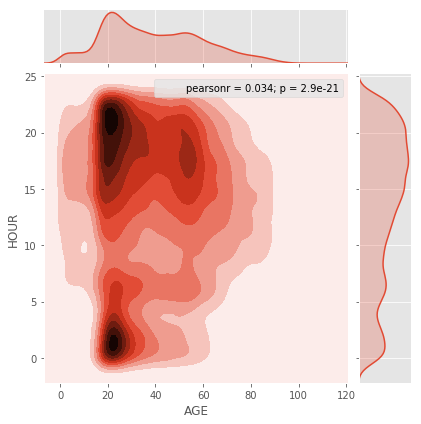

In [15]:
sns.jointplot(x="AGE", y="HOUR", data=df, kind="kde");

Here we can see that for the high peak around 20 the most frequent hours of accidents are in the evening into the late night.